## Note
As other nltk versions exist some bugs in calculating bleu, the the experiment should be ran in nltk 3.6.1 

In [1]:
!pip install nltk==3.6.1

^C


##  util


In [1]:
import sys
sys.path.append("../..")
sys.path.append("../../metrics")
from metrics.evaluate import read_to_list
from bleu.codenn_bleu import codenn_smooth_bleu
from bleu.google_bleu import compute_bleu
from bleu.rencos_bleu import Bleu as recos_bleu
import prettytable as pt
import numpy as np
import os

In [2]:

def get_mean_std(arr):
    arr_mean = np.mean(arr)
    arr_std = np.std(arr, ddof=1)
    return arr_mean ,  arr_std
def show_dict(all_bleu):
        tb = pt.PrettyTable()
        tb.field_names = all_bleu.keys()
        tb.add_row(all_bleu.values())
        print(tb)

In [3]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

In [4]:
def get_codenn_score(refs, preds):
    r_str_list = []
    p_str_list = []
    for r, p in zip(refs, preds):
        if len(r[0]) == 0 or len(p) == 0:
            continue
        r_str_list.append([" ".join([str(token_id) for token_id in r[0]])])
        p_str_list.append(" ".join([str(token_id) for token_id in p]))
    try:
        bleu_list = codenn_smooth_bleu(r_str_list, p_str_list)
    except:
        bleu_list = [0, 0, 0, 0]
    codenn_bleu = bleu_list[0]
    codenn_bleu = round(codenn_bleu,4)
    return codenn_bleu

In [5]:
def get_bleu_cn(refs,preds):
    r_str_list = []
    p_str_list = []
    for r, p in zip(refs, preds):
        if len(r[0]) == 0 or len(p) == 0:
            continue
        r_str_list.append([" ".join([str(token_id) for token_id in r[0]])])
        p_str_list.append(" ".join([str(token_id) for token_id in p]))
    try:
        bleu_list = codenn_smooth_bleu(r_str_list, p_str_list)
    except:
        bleu_list = [0, 0, 0, 0]
    codenn_bleu = bleu_list[0]
    codenn_bleu = round(codenn_bleu,4)
    return codenn_bleu
def get_bleu_dc(refs,preds):
    all_score = 0.0
    count = 0
    for r, p in zip(refs, preds):
        # nltk bug: https://github.com/nltk/nltk/issues/2204
        if len(p) == 1:
            continue
        score = nltk.translate.bleu(r, p, smoothing_function=SmoothingFunction().method4)
        all_score += score
        count += 1
    emse_bleu = round(all_score / count * 100, 4)
    return emse_bleu

In [6]:
from scipy import stats


def wilcoxon_signed_rank_test(y1, y2):
    statistic, pvalue = stats.wilcoxon(y1, y2)
    return pvalue


def get_score(r0, r1):
#     pvalue = wilcoxon_signed_rank_test(y1, y2)
    _, p_val_t_test = stats.ttest_ind(r0, r1, equal_var=False)
    _, p_val_wwu_test = stats.mannwhitneyu(r0, r1, alternative='two-sided') 
    return p_val_t_test, p_val_wwu_test


def get_pvalue_and_effect_size(all_score):
    models_name = list(all_score)
    for i in range(len(models_name)):
        for j in range(i + 1, len(models_name)):
            pvalue = get_score(all_score[models_name[i]], all_score[models_name[j]])
            print("{} and {}, t-test:pvalue is {}, WMW-test: pvalue is {}".format(models_name[i], models_name[j], pvalue[0], pvalue[1]))

In [7]:
def get_all_datset_result(approaches , diff_datasets,get_bleu_score):
#     scores = {}
    scores_p_test = {}
    for approach in approaches:
        scores_diff_dataset = {}
        latex_diff_dataset = {}
        for diff_dataset in diff_datasets:
            average_score = [] 
            for random_seed in range(3):
                refs_filename = os.path.join(diff_dataset, "test.gold")
                if  diff_dataset in ["FCM","FCM_project_large"]:
                    refs_filename = os.path.join(diff_dataset,approach, "test.gold")
                preds_filename = os.path.join(diff_dataset,approach, "random%s"%random_seed, "test.pred")
                preds = read_to_list(preds_filename)
                refs = read_to_list(refs_filename)
                refs = [[t] for t in refs[:len(preds)]]
                bleu_s = get_bleu_score(refs, preds)
                average_score.append(bleu_s)
                if diff_dataset in list(scores_p_test):
                    scores_p_test[diff_dataset].append(bleu_s)
                else:
                    scores_p_test[diff_dataset] = [bleu_s]
            mean, std_var = get_mean_std(average_score)
            scores_diff_dataset[diff_dataset] = "%.2f+-%.2f"%(mean, std_var)
            latex_diff_dataset[diff_dataset] = "&%.2f$\pm$%.2f"%(mean, std_var)
#         scores[diff_dataset] = scores_diff_dataset
        print(15*"*"+approach+15*"*")
#         print(approach)
#         print(average_score)
        
        show_dict(scores_diff_dataset)
    print("-------------Significant Testing---------------")
#     print(scores_p_test)
    if len(scores_p_test) >3:
        get_pvalue_and_effect_size(dict(list(scores_p_test.items())[:3]))
        get_pvalue_and_effect_size(dict(list(scores_p_test.items())[3:]))
    else:
        get_pvalue_and_effect_size(scores_p_test)
#         show_dict(latex_diff_dataset)
#         print(" ".join(list(latex_diff_dataset.values())))
#     save_pickle_data("./", save_score_filename, scores)

## Performance in Different Dtaset: TCL FCM CSN

In [8]:
diff_datasets = ["TLC" ,"FCM", "CSN"]
approaches = ["codenn","deepcom", "astattgru", "rencos", "ncs" ]

In [9]:
get_all_datset_result(approaches , diff_datasets,get_bleu_dc)

***************codenn***************
+-------------+-------------+------------+
|     TLC     |     FCM     |    CSN     |
+-------------+-------------+------------+
| 28.24+-0.19 | 12.64+-0.13 | 3.32+-0.09 |
+-------------+-------------+------------+
***************deepcom***************
+-------------+------------+------------+
|     TLC     |    FCM     |    CSN     |
+-------------+------------+------------+
| 15.65+-2.12 | 9.12+-0.03 | 1.98+-0.30 |
+-------------+------------+------------+
***************astattgru***************
+-------------+-------------+------------+
|     TLC     |     FCM     |    CSN     |
+-------------+-------------+------------+
| 25.90+-0.79 | 15.58+-0.11 | 5.01+-0.27 |
+-------------+-------------+------------+
***************rencos***************
+-------------+-------------+------------+
|     TLC     |     FCM     |    CSN     |
+-------------+-------------+------------+
| 42.46+-0.05 | 15.47+-0.00 | 6.65+-0.05 |
+-------------+-------------+-------

## corpus size

In [10]:
diff_datasets = ["FCM_method_small", "FCM_method_medium","FCM_method_large","CSN_method_small","CSN_method_medium",]
approaches = ["codenn","deepcom", "astattgru", "rencos", "ncs" ]

In [11]:
get_all_datset_result(approaches , diff_datasets,get_bleu_dc)

***************codenn***************
+------------------+-------------------+------------------+------------------+-------------------+
| FCM_method_small | FCM_method_medium | FCM_method_large | CSN_method_small | CSN_method_medium |
+------------------+-------------------+------------------+------------------+-------------------+
|   10.37+-0.17    |    14.76+-0.17    |   18.68+-0.26    |    5.20+-0.01    |    12.71+-0.23    |
+------------------+-------------------+------------------+------------------+-------------------+
***************deepcom***************
+------------------+-------------------+------------------+------------------+-------------------+
| FCM_method_small | FCM_method_medium | FCM_method_large | CSN_method_small | CSN_method_medium |
+------------------+-------------------+------------------+------------------+-------------------+
|    8.99+-0.06    |    10.87+-0.20    |   11.65+-0.36    |    7.57+-0.74    |     7.85+-1.07    |
+------------------+--------------

## data splitting way

In [12]:
diff_datasets = ["CSN_project_medium", "CSN_class_medium","CSN_method_medium","FCM_project_large","FCM_method_large",]
approaches = ["codenn","deepcom", "astattgru", "rencos", "ncs" ]

In [13]:
get_all_datset_result(approaches , diff_datasets,get_bleu_dc)

***************codenn***************
+--------------------+------------------+-------------------+-------------------+------------------+
| CSN_project_medium | CSN_class_medium | CSN_method_medium | FCM_project_large | FCM_method_large |
+--------------------+------------------+-------------------+-------------------+------------------+
|     3.32+-0.09     |    9.57+-0.15    |    12.71+-0.23    |    12.64+-0.13    |   18.68+-0.26    |
+--------------------+------------------+-------------------+-------------------+------------------+
***************deepcom***************
+--------------------+------------------+-------------------+-------------------+------------------+
| CSN_project_medium | CSN_class_medium | CSN_method_medium | FCM_project_large | FCM_method_large |
+--------------------+------------------+-------------------+-------------------+------------------+
|     1.98+-0.30     |    6.14+-0.12    |     7.85+-1.07    |     9.12+-0.03    |   11.65+-0.36    |
+---------------

## duplication ratio

In [14]:
def get_dup_ratio(approaches ,get_bleu_score,dup_ratios=[0,1,3,5,7,9]):
    scores = {}
    diff_dataset="TLC_diff_dup"
    for approach in approaches:
        scores_diff_dup_ratio = {}
        for dup_ratio in dup_ratios: 
            refs_filename = os.path.join(diff_dataset, approach, "0%s"%dup_ratio, "test.gold")
            preds_filename = os.path.join(diff_dataset,approach, "0%s"%dup_ratio, "test.pred")
            refs = read_to_list(refs_filename)
            refs = [[t] for t in refs]
            preds = read_to_list(preds_filename)
            bleu_s = get_bleu_score(refs, preds)
            scores_diff_dup_ratio["0."+ str(dup_ratio)] = "%.2f "%(bleu_s)
        print(30*"*")
        print(approach)
        show_dict(scores_diff_dup_ratio)



In [15]:
approaches = ["codenn","deepcom", "astattgru", "rencos", "ncs" ]

In [16]:
get_dup_ratio(approaches ,get_bleu_dc)

******************************
codenn
+-------+-------+--------+--------+--------+--------+
|  0.0  |  0.1  |  0.3   |  0.5   |  0.7   |  0.9   |
+-------+-------+--------+--------+--------+--------+
| 7.34  | 9.10  | 12.92  | 17.12  | 20.85  | 24.75  |
+-------+-------+--------+--------+--------+--------+
******************************
deepcom
+-------+-------+--------+--------+--------+--------+
|  0.0  |  0.1  |  0.3   |  0.5   |  0.7   |  0.9   |
+-------+-------+--------+--------+--------+--------+
| 5.83  | 7.65  | 11.17  | 14.69  | 18.15  | 22.23  |
+-------+-------+--------+--------+--------+--------+
******************************
astattgru
+-------+--------+--------+--------+--------+--------+
|  0.0  |  0.1   |  0.3   |  0.5   |  0.7   |  0.9   |
+-------+--------+--------+--------+--------+--------+
| 6.62  | 10.19  | 17.45  | 24.47  | 31.92  | 39.06  |
+-------+--------+--------+--------+--------+--------+
******************************
rencos
+--------+--------+--------+-

In [1]:
codenn = [7.34, 9.1, 12.92, 17.12, 20.85, 24.75]
deepcom = [5.83, 7.65, 11.17, 14.69, 18.15, 22.23]
astattgru=[6.62, 10.19, 17.45, 24.47, 31.92, 39.06]
rencos = [24.21, 31.66, 46.47, 61.28, 76.07, 90.91]
ncs = [13.67, 20.24, 28.76, 37.6, 45.77, 55.12]

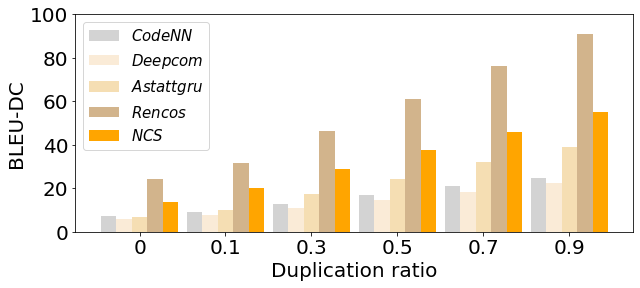

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import math
import os


x = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
codenn_lable = '$CodeNN$'
deppcom_lable= '$Deepcom$'
astattgru_label = '$Astattgru$'
rencos_lable = "$Rencos$"
ncs_lable = "$NCS$"
plt.rc('text', usetex = False)
plt.figure(figsize=(10,4))
width = 0.18
x = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
index = np.arange(len(x))
r1 = plt.bar(index,codenn,width,color='lightgray',label=codenn_lable)
r2 = plt.bar(index+width,deepcom,width,color='antiquewhite',label=deppcom_lable)
r3 = plt.bar(index+width+width, astattgru,width,color='wheat',label=astattgru_label)
r4 = plt.bar(index+width+width+width,rencos,width, color='tan',label=rencos_lable)
r5 = plt.bar(index+width+width+width+width,ncs,width,color='orange',label=ncs_lable)

plt.xticks(index+width+width ,x, fontsize=20)
plt.yticks(fontsize=20)
plt.ylim( ymax=100)
plt.legend(fontsize=15, ncol=1, loc='upper left')
# plt.legend()
plt.xlabel("Duplication ratio", fontsize=20)
plt.ylabel("BLEU-DC", fontsize=20)
plt.savefig('diff_dup_ratio_bleu_dc.pdf', format='pdf', dpi=1000, bbox_inches = 'tight',pad_inches=0.1)
plt.show()